In [1]:
import h5py
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
%matplotlib nbagg

In [2]:
lambdas = 418.2123 + 0.1465645*np.arange(1,2049)
nus = 299792458 / (lambdas[400:2047] * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=1647, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(70),signal.tukey(40)[20:40], np.zeros(1557), np.zeros(1647)))
filter3 = np.concatenate((np.zeros(100), np.ones(100)))

In [17]:
# choose the data file(s):
datafiles = []
for file in glob.glob('/sf/alvra/data/p18647/raw/PSEN_bkg/*.BSREAD.h5'):
    datafiles.append(file)
datafiles = sorted(datafiles)
datafiles

['/sf/alvra/data/p18647/raw/PSEN_bkg/run_000413.BSREAD.h5']

In [18]:
for file in datafiles:
    # Load spectral data and spectrometer calibration
    with h5py.File(file, 'r') as f:
        back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
        sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]

<IPython.core.display.Javascript object>


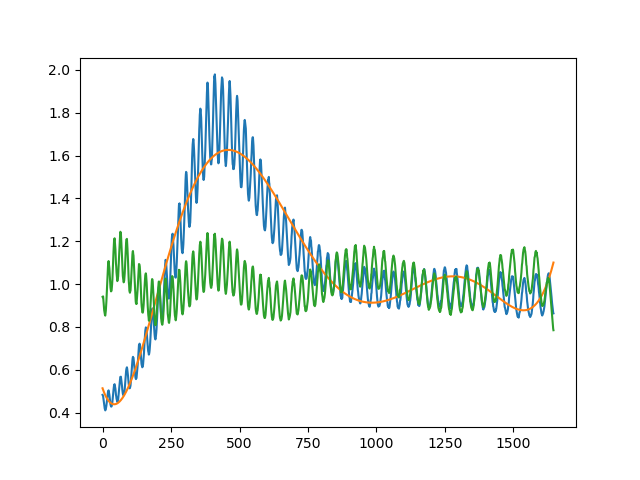

In [25]:
back_avg = np.mean(back, axis=0)
sig_avg = np.mean(sig, axis=0)
background_avg = sig_avg/back_avg

# polyfit a smooth background...
def polyfxn(x, a, b, c, d, e, f, g, h):
    return a*x**7 + b*x**6 + c*x**5 + d*x**4 + e*x**3 + f*x**2 + g*x + h

fitParams, _ = optimize.curve_fit(polyfxn, lambdas[400:2047], background_avg[400:2047], p0=[1, 1, 1, 1, 1, 1, 1, 1])

background_from_fit = polyfxn(lambdas[400:2047], *fitParams)


plt.figure()
#plt.plot(back_avg)
#plt.plot(sig_avg)
plt.plot(background_avg[400:2047])
plt.plot(background_from_fit)
plt.plot(background_avg[400:2047]/background_from_fit)
plt.show()


In [26]:
fitParams

array([-1.64067787e-17,  1.73619540e-12, -6.15626687e-09,  9.17792407e-06,
       -7.28913043e-03,  3.24549187e+00, -7.67484913e+02,  7.52747575e+04])

In [27]:
#plt.figure()
#plt.plot(background_from_fit)
#plt.show()
#background_from_fit

#np.savetxt('/sf/alvra/data/p18647/scratch/2020-09-03-23:30-psen-background.txt', background_from_fit)

In [28]:
# choose the data file(s):
datafiles = []
for file in glob.glob('/sf/alvra/data/p18647/raw/PSEN_calib4/*.BSREAD.h5'):
    datafiles.append(file)
datafiles = sorted(datafiles)

background_from_fit = np.loadtxt('/sf/alvra/data/p18647/scratch/2020-09-05-15:15-psen-background.txt')

datafiles

['/sf/alvra/data/p18647/raw/PSEN_calib4/run_001056.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001057.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001058.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001059.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001060.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001061.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001062.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001063.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001064.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001065.BSREAD.h5',
 '/sf/alvra/data/p18647/raw/PSEN_calib4/run_001066.BSREAD.h5']

In [29]:
timingMean = []
timingStd = []
stagePos = []
edgeSigMean = []

for file in datafiles:
    print(file)
    # Load spectral data and spectrometer calibration
    with h5py.File(file, 'r') as f:
        events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
        back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
        sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]
        #globalGlobi = f['/data/SLAAR11-LMOT-M452:ENC_1_BS/data'][:]
        #laser_diode = f['data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data'][:]

    # logic for whether we start on a delayed shot or not
    #if events[0, 21].astype(bool) == True:
    #    start = 0
    #else:
    #    start = 2

    edgePos = [] # edge positions
    edgeSig = []

    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k, 400:2047] / back[k, 400:2047]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
#        sig4inter = interp1d(nus_new, sig4invreal[0:1647], kind='cubic')
#        sig5 = sig4inter(nus)
        sig4savgol = savgol_filter(sig4invreal[0:1647], 201, 1)
        sig5 = sig4savgol
        
        # cross correlation, isolate the peak, save it if we have no division by zero errors
        xcorr2 = np.correlate(sig5, filter3, 'same')
        peak2 = savgol_filter(np.diff(xcorr2)[250:1647-250], 201, 3)
        peakxcorr, _ = find_peaks(peak2[:],height=np.max(peak2[:]))
        if (peakxcorr > 0) & (peak2.max() > 0.05): 
            edgePos.append(peakxcorr[0])
        edgeSig.append(sig5)
            
    timingMean.append(np.mean(edgePos))
    print(np.mean(edgePos))
    timingStd.append(np.std(edgePos))
    print(np.std(edgePos))
    edgeSigMean.append(np.mean(edgeSig))
    #stagePos.append(globalGlobi)

/sf/alvra/data/p18647/raw/PSEN_calib4/run_001056.BSREAD.h5
831.1791791791792
31.718590698876422
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001057.BSREAD.h5
778.18
14.736539620955796
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001058.BSREAD.h5
734.6766766766767
23.618221502761802
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001059.BSREAD.h5
664.4264264264265
56.83753026996803
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001060.BSREAD.h5
603.3583583583584
86.91681218238308
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001061.BSREAD.h5
530.6943887775551
122.05568798920513
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001062.BSREAD.h5
485.64764764764766
143.99155370892933
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001063.BSREAD.h5
449.9159159159159
161.79121525679696
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001064.BSREAD.h5
400.9429429429429
186.16722585818235
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001065.BSREAD.h5
368.32164328657313
202.77538673971227
/sf/alvra/data/p18647/raw/PSEN_calib4/run_001066.BS

[ -0.58965587 562.81259031]


<IPython.core.display.Javascript object>


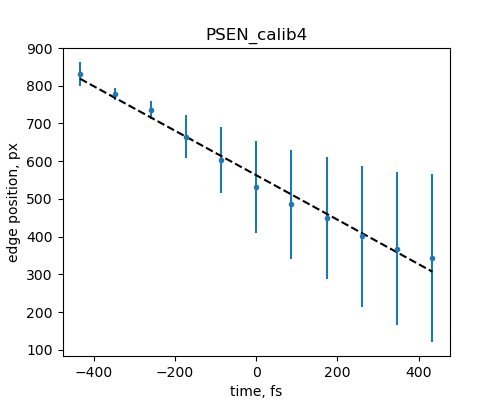

1.695904427772329


In [32]:
xaxis = 86.72679*np.arange(0,11)
xaxis -= np.mean(xaxis)

def straightLine(x, a, b):
    return a*x + b

fitParams_lines, _ = optimize.curve_fit(straightLine, xaxis, timingMean, p0=[1, 550])
psen_calib_from_fit = straightLine(xaxis, *fitParams_lines)
print(fitParams_lines)

plt.figure(figsize=(5,4))
plt.title('PSEN_calib4')
#plt.plot(xaxis, timingMean)
plt.plot(xaxis, psen_calib_from_fit, '--', color='black')
plt.errorbar(xaxis, timingMean, yerr=timingStd, fmt='.', )
plt.xlabel('time, fs')
plt.ylabel('edge position, px')
plt.show()
print(-1/fitParams_lines[0])

In [180]:
timingMean = []
timingStd = []
stagePos = []
edgeSigMean = []
edgeAmp = []

for file in datafiles:
    print(file)
    # Load spectral data and spectrometer calibration
    with h5py.File(file, 'r') as f:
        events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
        back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
        sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]

    edgePos = [] # edge positions
    edgeSig = []

    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k, 400:2047] / back[k, 400:2047]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, et cetera
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
        sig4inter = interp1d(nus_new, sig4invreal[0:1647], kind='cubic')
        sig5 = sig4inter(nus)
#        sig5 = sig4invreal
        sig5gaussO0 = gaussian_filter1d(sig5, 95) # gaussian filtering with sigma = 66px
        sig5gaussO1 = gaussian_filter1d(sig5, 95, order=1) # gaussian derivative filter to recover the peak
        if sig5gaussO1.max() > 0.00035:
            edgePos.append(np.argmax(sig5gaussO1))
        edgeSig.append(sig5gaussO0)
        edgeAmp.append(np.max(sig5gaussO1))
            
    timingMean.append(np.mean(edgePos))
    print(np.mean(edgePos))
    timingStd.append(np.std(edgePos))
    print(np.std(edgePos))
    edgeSigMean.append(np.mean(edgeSig))
    #stagePos.append(globalGlobi)

/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000309.BSREAD.h5
1021.20625
18.480878702165832
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000311.BSREAD.h5
952.5
19.58432684541814
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000313.BSREAD.h5
876.0961098398169
23.383185659664562
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000315.BSREAD.h5
808.6935866983373
18.426039658371778
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000318.BSREAD.h5
733.0229166666667
13.679877856169703
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000320.BSREAD.h5
691.1327967806841
12.043619198786633
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000322.BSREAD.h5
645.642
10.455708297384735
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000324.BSREAD.h5
602.724
10.667887513467697
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000326.BSREAD.h5
557.664
10.581072913462037
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000329.BSREAD.h5
515.3
11.479634140511623
/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000331.BSREAD.h5
466.34
11.938525872150214


[-6.26601776e-01  7.15483787e+02]


<IPython.core.display.Javascript object>


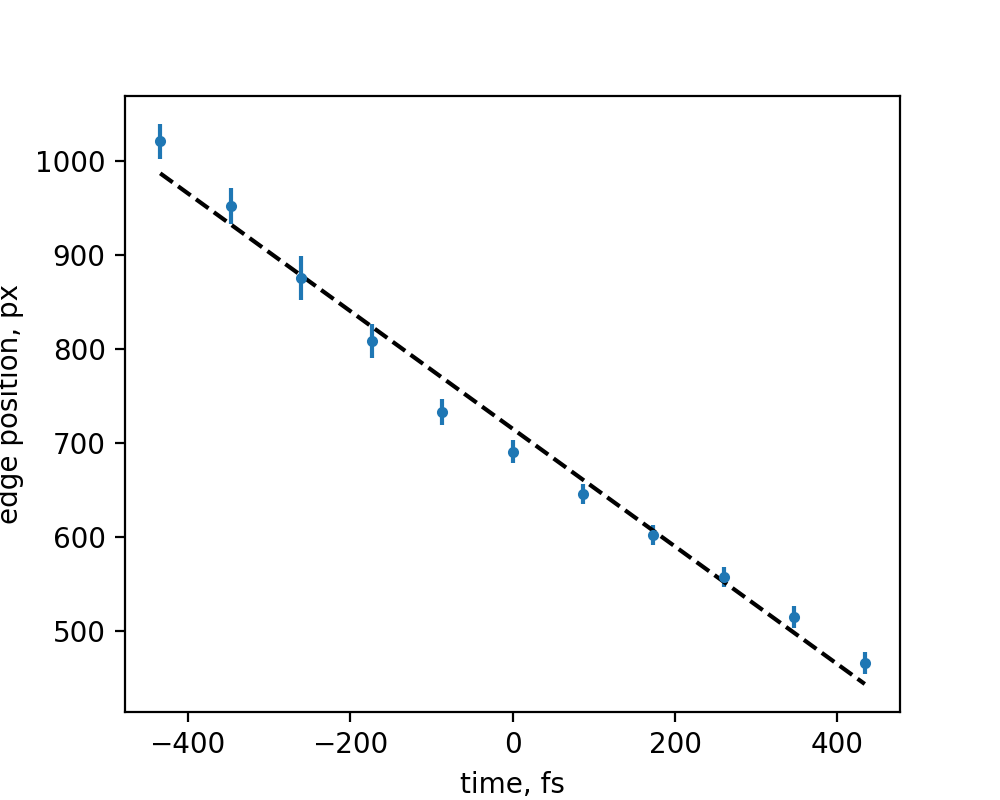

1.5959099365182228


In [181]:
xaxis = 86.72679*np.arange(0,11)
xaxis -= np.mean(xaxis)

def straightLine(x, a, b):
    return a*x + b

fitParams_lines, _ = optimize.curve_fit(straightLine, xaxis, timingMean, p0=[1, 550])
psen_calib_from_fit = straightLine(xaxis, *fitParams_lines)
print(fitParams_lines)

plt.figure(figsize=(5,4))
#plt.plot(xaxis, timingMean)
plt.plot(xaxis, psen_calib_from_fit, '--', color='black')
plt.errorbar(xaxis, timingMean, yerr=timingStd, fmt='.', )
plt.xlabel('time, fs')
plt.ylabel('edge position, px')
plt.show()
print(-1/fitParams_lines[0])

In [167]:
timingMean = []
timingStd = []
edgeSigMean = []

file = '/sf/alvra/data/p18594/raw/PSEN_calib_1/run_000322.BSREAD.h5'
    # Load spectral data and spectrometer calibration
with h5py.File(file, 'r') as f:
    events = f['/data/SAR-CVME-TIFALL5:EvtSet/data'][:]
    back = f['/data/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
    sig = f['/data/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]

edgePos = [] # edge positions
edgeSig = []
edgeAmp = [] # amplitudes

for sigma in range(10, 200, 20):

    edgePos = [] # edge positions
    
    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k, 400:2047] / back[k, 400:2047]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, et cetera
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
        sig4inter = interp1d(nus_new, sig4invreal[0:1647], kind='cubic')
        sig5 = sig4inter(nus)
        sig5gaussO0 = gaussian_filter1d(sig5, sigma) # gaussian filtering with sigma = 66px
        sig5gaussO1 = gaussian_filter1d(sig5, sigma, order=1) # gaussian derivative filter to recover the peak
        if sig5gaussO1.max() > 0.00022:
            edgePos.append(np.argmax(sig5gaussO1))
        edgeSig.append(sig5gaussO0)
        edgeAmp.append(sig5gaussO1.max())
            
    print(sigma)
    timingMean.append(np.mean(edgePos))
    print(np.mean(edgePos))
    timingStd.append(np.std(edgePos))
    print(np.std(edgePos))
    edgeSigMean.append(np.mean(edgeSig))

10
9.0
0.0
30
630.024
13.37951508837297
50
642.562
11.498789327577056
70
646.274
10.676091232281598
90
645.99
10.495232250884207
110
644.082
10.588450122657235
130
641.244
11.099029867515448
150
637.76
11.977579054216259
170
633.843373493976
13.213096151344656
190
629.76875
14.72040330417275


<IPython.core.display.Javascript object>


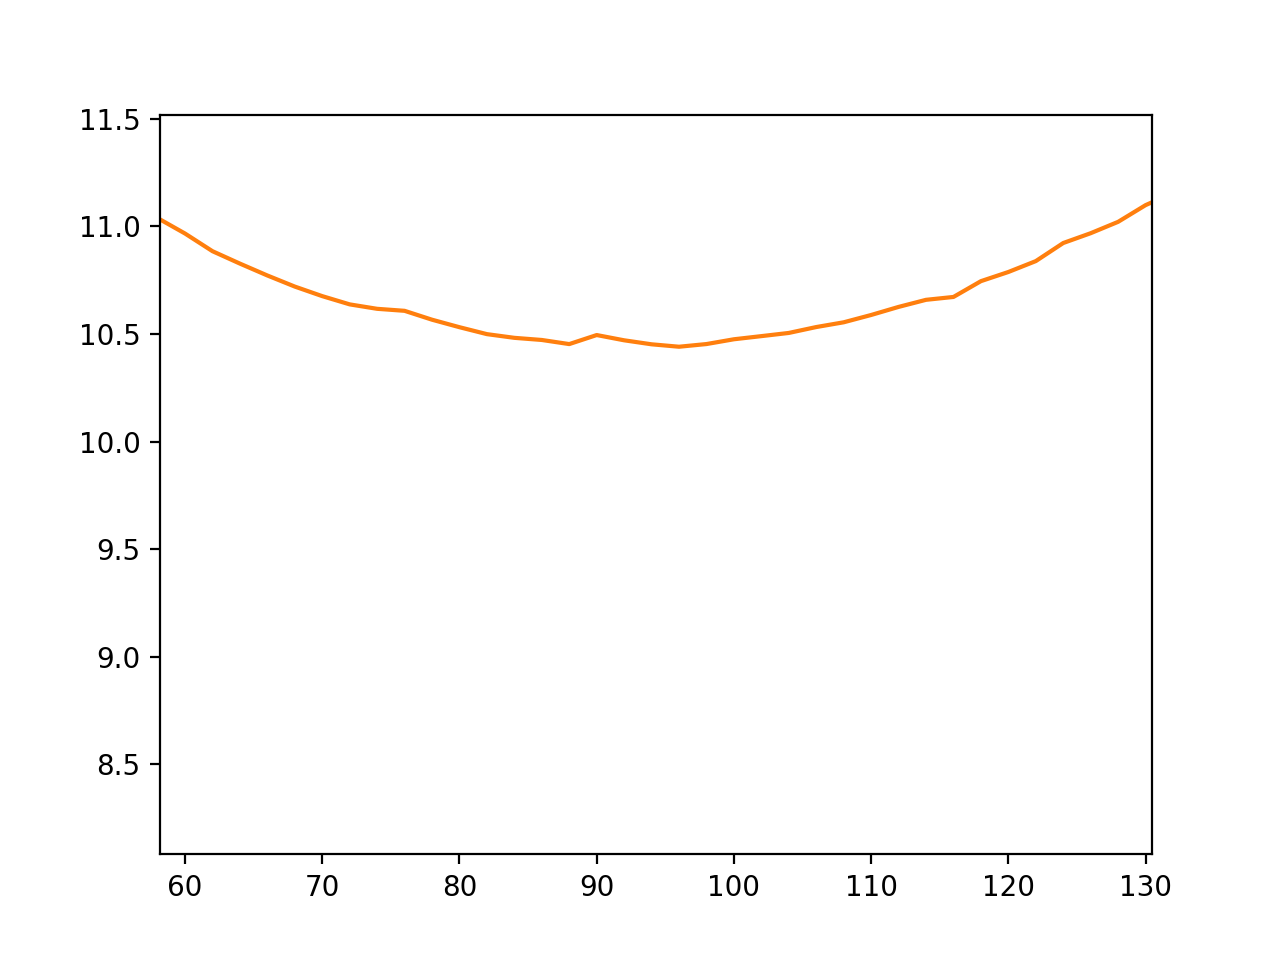

In [149]:
sigmas = np.arange(10, 200, 2)
plt.figure()
plt.plot(sigmas, timingMean)
plt.plot(sigmas, timingStd)
#plt.plot(edgePos)

<IPython.core.display.Javascript object>


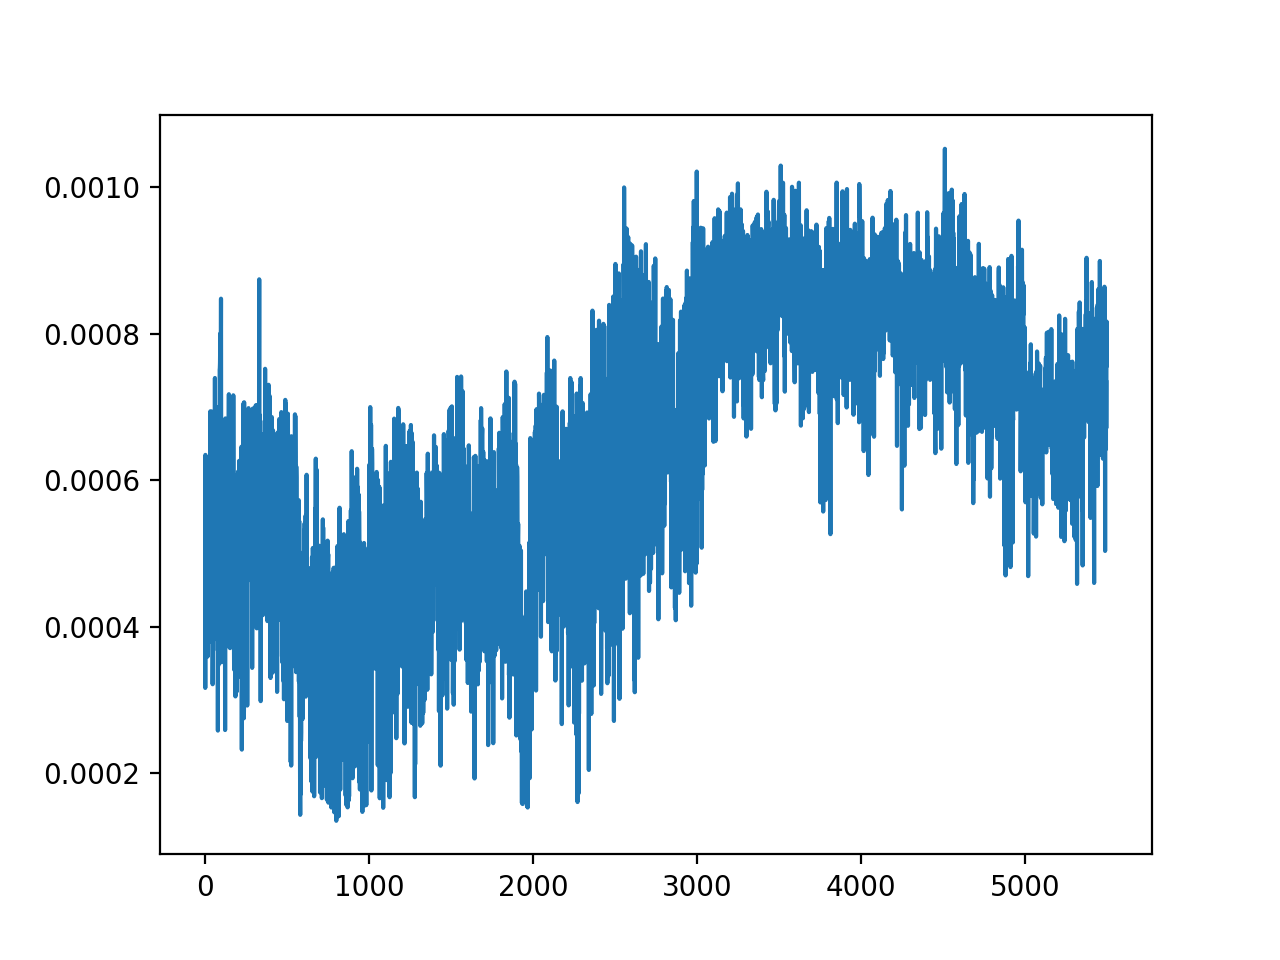

In [182]:
plt.figure()
plt.plot(edgeAmp)

<IPython.core.display.Javascript object>


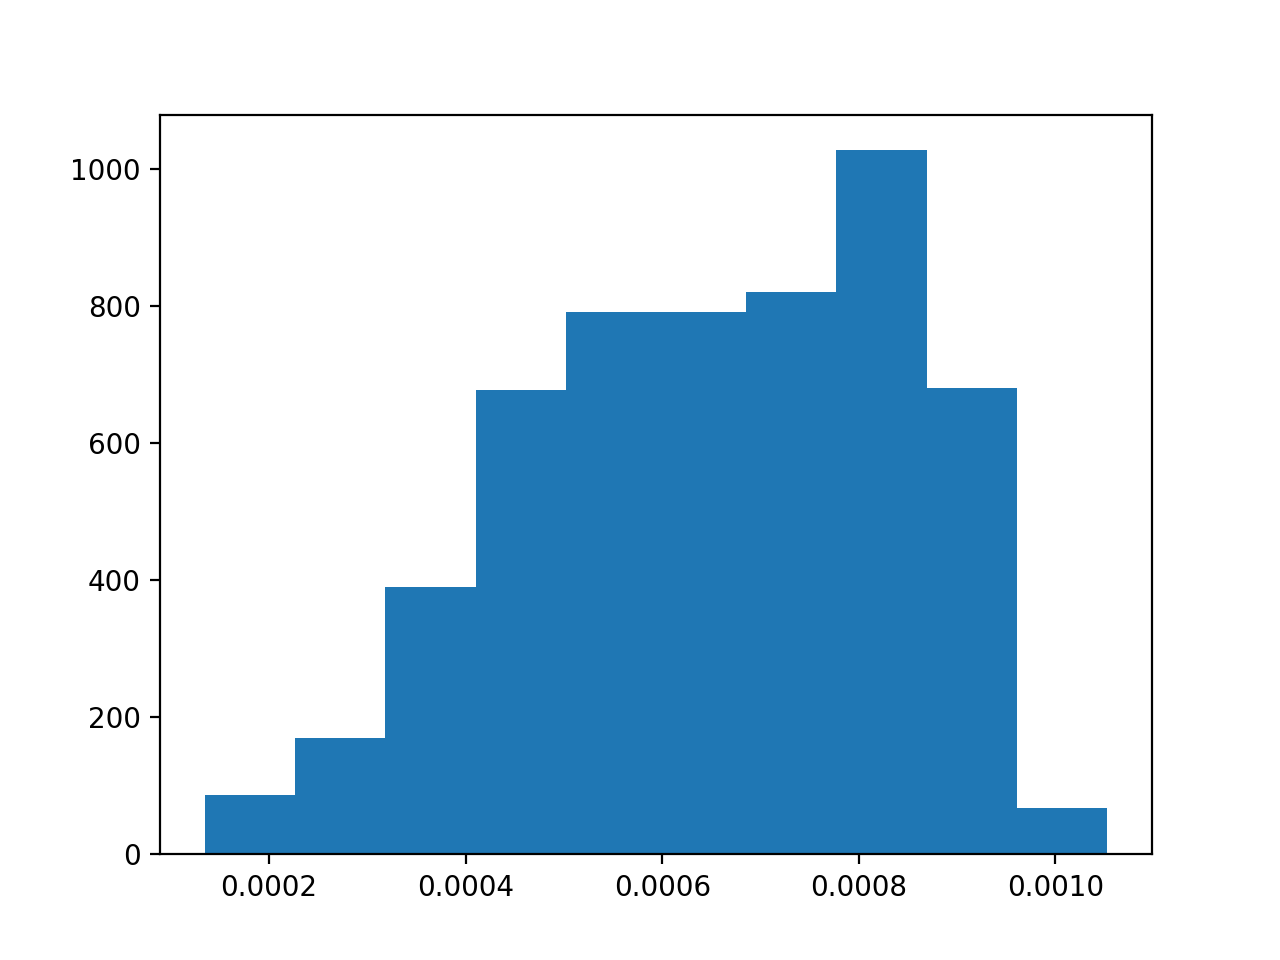

(array([  87.,  170.,  390.,  677.,  791.,  791.,  820., 1027.,  680.,
          67.]),
 array([0.000135  , 0.00022674, 0.00031847, 0.00041021, 0.00050195,
        0.00059369, 0.00068543, 0.00077716, 0.0008689 , 0.00096064,
        0.00105238]),
 <a list of 10 Patch objects>)

In [183]:
plt.figure()
plt.hist(edgeAmp)